In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torchvision, torch

In [3]:
import sys, os
sys.path.insert(0,"../torchxrayvision/")
import torchxrayvision as xrv
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F
import glob
import numpy as np
import skimage, skimage.filters
%matplotlib inline
import captum, captum.attr
import torch, torch.nn
import pickle
import attribution
import pandas as pd
import datasets
import shutil
import json
import glob

In [4]:
def full_frame(width=None, height=None):
    import matplotlib as mpl
    mpl.rcParams['savefig.pad_inches'] = 0
    figsize = None if width is None else (width, height)
    fig = plt.figure(figsize=figsize)
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.autoscale(tight=True)

In [5]:
dmerge = datasets.get_data("pc")

PC_Dataset num_samples=91658 views=['PA'] data_aug=None


In [6]:
ae = xrv.autoencoders.ResNetAE(weights="101-elastic").cuda()

In [7]:
model = xrv.models.DenseNet(weights="all").cuda()

In [8]:
print(model.pathologies)
print(model)

['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'Lung Lesion', 'Fracture', 'Lung Opacity', 'Enlarged Cardiomediastinum']
XRV-DenseNet121-all


In [9]:
for_eval = [
            "Cardiomegaly",
            "Atelectasis",
            "Effusion",
            "Consolidation",
            "Edema",
            "Mass"
            ]

In [10]:
methods = ["image", "grad", "guided", "integrated", "latentshift-max"]
temp_path = "/lscratch/joecohen/SDS-2342-ASDAA"

In [11]:
for_eval

['Cardiomegaly', 'Atelectasis', 'Effusion', 'Consolidation', 'Edema', 'Mass']

In [12]:
target = "Mass"
label = 1

In [13]:
# dwhere = np.where(dmerge.csv.has_masks & (dmerge.labels[:,dmerge.pathologies.index(target)]  == 1))[0]
# dwhere[:10]

In [14]:
# print(target)
# idx = 17 #17, 49 Cardio NIH 

# sample = dmerge[dwhere[idx]]
# csv = dmerge.csv.iloc[dwhere[idx]]
# image = torch.from_numpy(sample["img"]).unsqueeze(0).cuda()

In [15]:
print(target)
idx = 19900 #Mass  PC. 142787305345083026075915680309419147857

sample = dmerge[idx]
csv = dmerge.csv.iloc[idx]
image = torch.from_numpy(sample["img"]).unsqueeze(0).cuda()

Mass


[0.7235052] -170 7


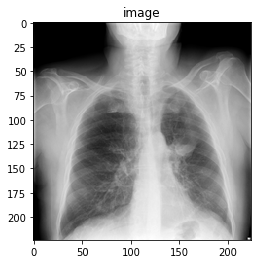

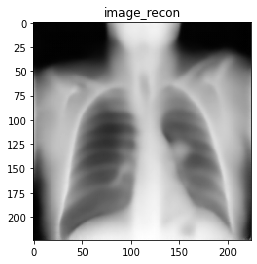

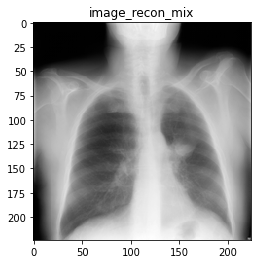

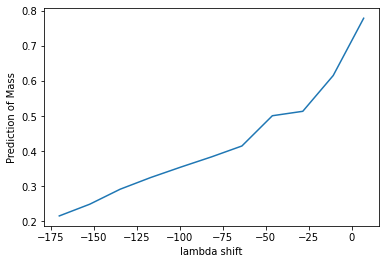

In [16]:
temp_path = "/lscratch/joecohen/SDS-2342-ASDAA"
a = attribution.compute_attribution(image.cuda(), "latentshift-max", model, target, plot=True, ae=ae);


tensor([0.7918])
[0.7235052] -170 7


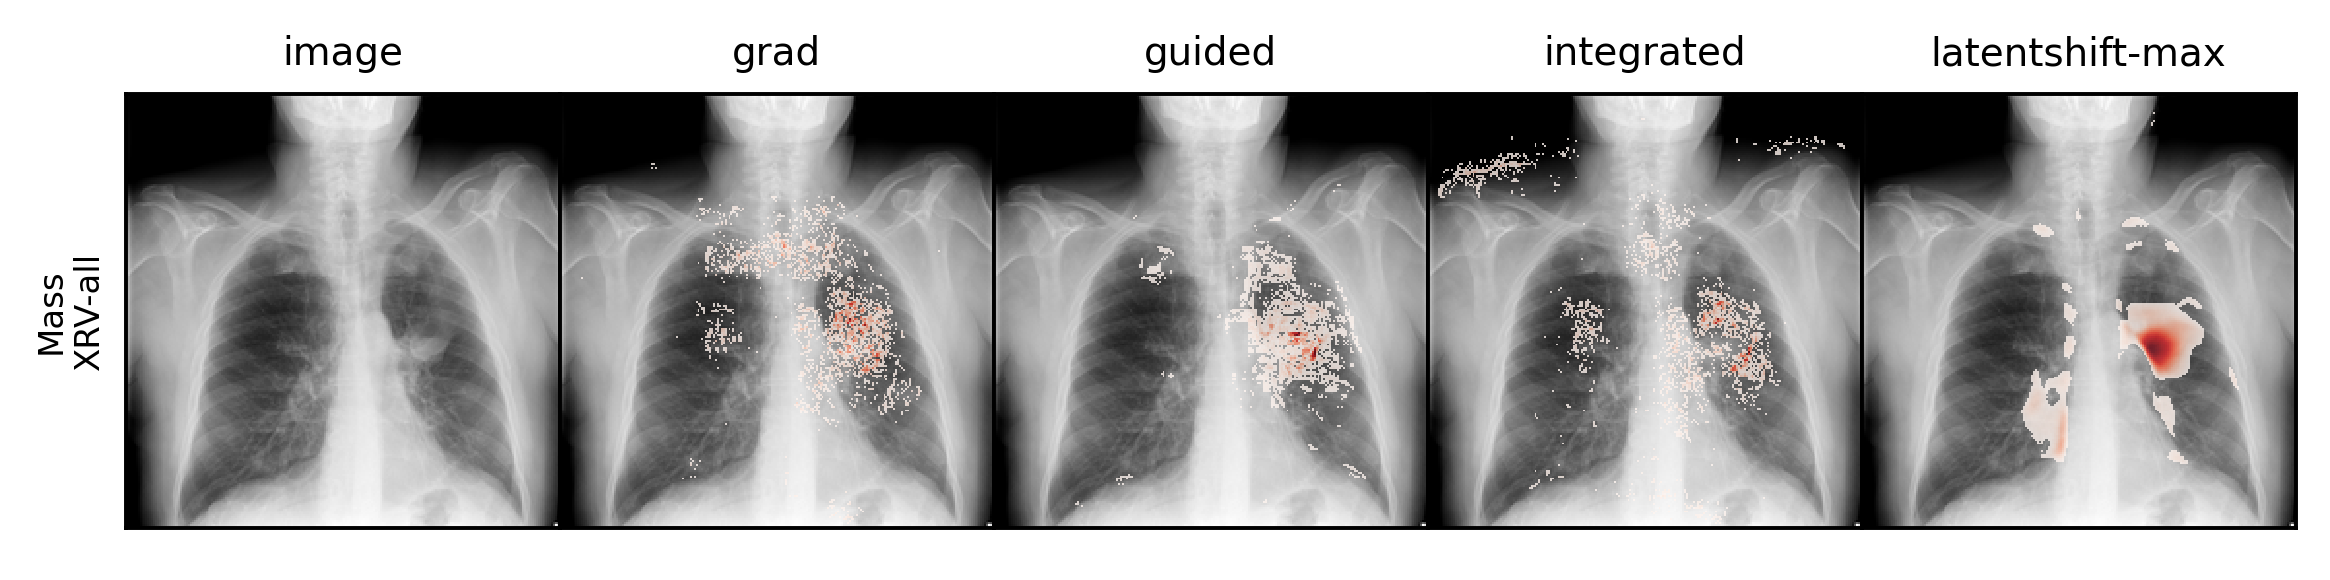

In [20]:
attribution.generate_attributions(sample, model, target, ae, temp_path, dmerge)

[0.7235052] -170 7
0
10
20
module load ffmpeg;ffmpeg -loglevel quiet -stats -y -i /lscratch/joecohen/SDS-2342-ASDAA/image-%d-a.png -c:v libx264 -profile:v baseline -level 3.0 -pix_fmt yuv420p 'test.mp4'


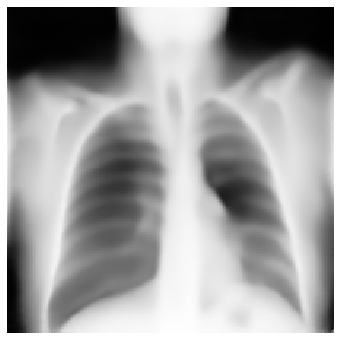

In [179]:
attribution.generate_video(image.cuda(), model, target, ae, temp_path, target_filename="test", border=False, show=True)

In [21]:
params = attribution.compute_attribution(image.cuda(), "latentshift", model, target, ret_params=True, ae=ae)


[0.7235052] -170 7


In [22]:
params.keys()

dict_keys(['dimgs', 'lambdas', 'y', 'initial_pred'])

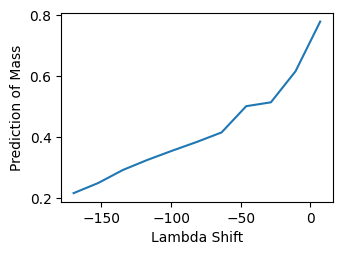

In [23]:
fig, ax = plt.subplots(1,1, figsize=(3.5,2.5), dpi=100)
plt.plot(params["lambdas"],params["y"])
plt.xlabel("Lambda Shift");
plt.ylabel("Prediction of " + target);
plt.show()

In [24]:
dimgs = np.concatenate(params["dimgs"],1)[0]

In [25]:
np.concatenate(dimgs,1).shape

(224, 2464)

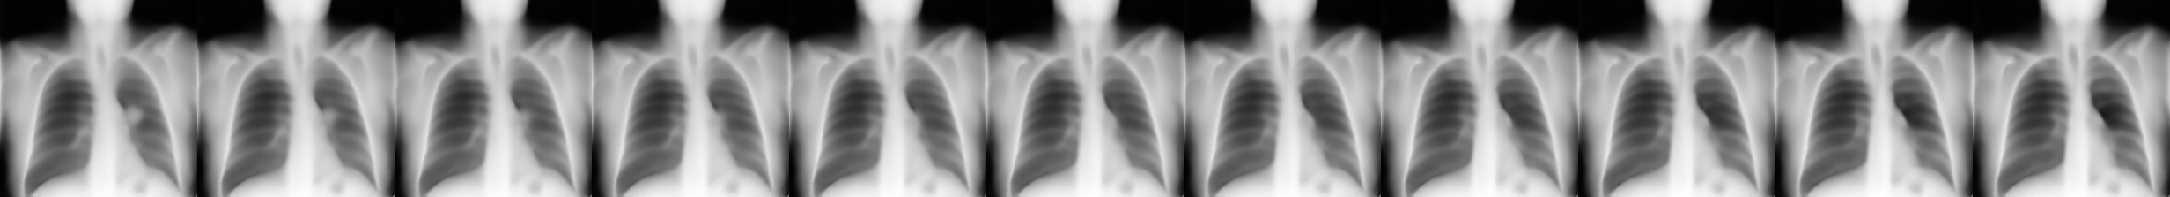

In [277]:
fig, ax = plt.subplots(1,1, figsize=(8,3), dpi=350)
plt.imshow(np.concatenate(dimgs,1), interpolation='none', cmap="gray");
plt.axis('off');

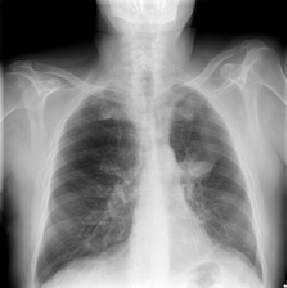

In [282]:
full_frame()
plt.imshow(image.detach().cpu().numpy()[0][0], interpolation='none', cmap="gray")
plt.show()

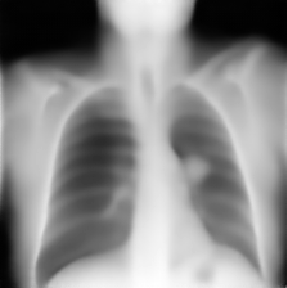

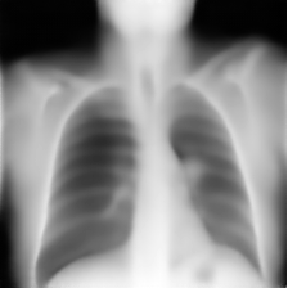

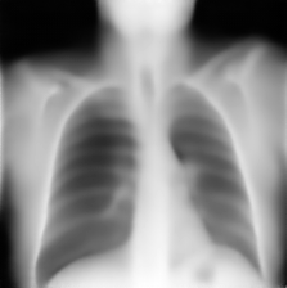

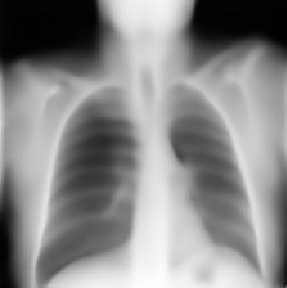

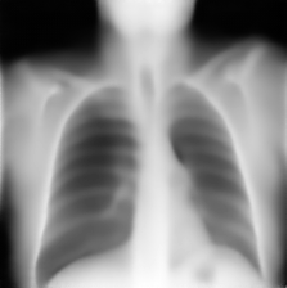

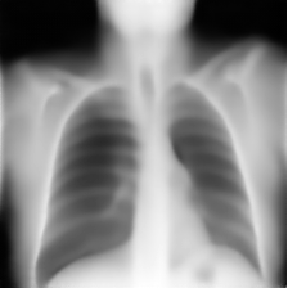

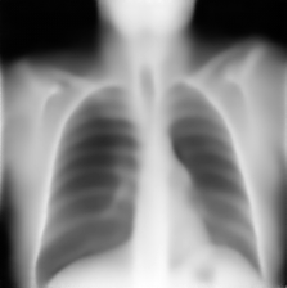

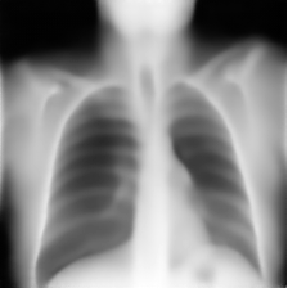

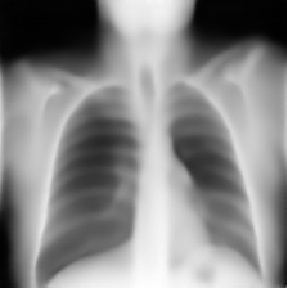

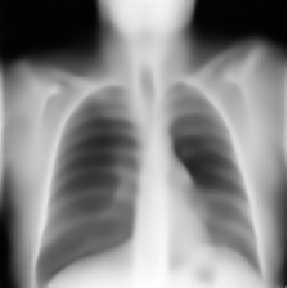

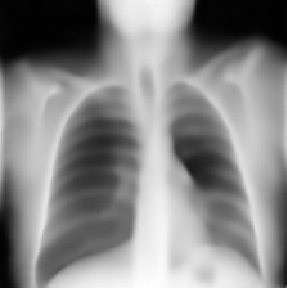

In [279]:
for img in dimgs:
    full_frame()
    plt.imshow(img, interpolation='none', cmap="gray")
    plt.show()

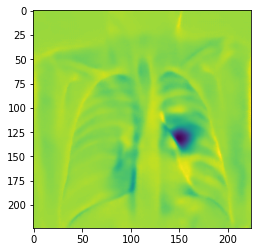

In [223]:
plt.imshow(dimgs[0] -  dimgs[-1]);

In [224]:
import opticalflow

In [225]:
#dimgs = list(reversed(dimgs))

In [285]:
uu = []
vv = []
for i in range(len(dimgs)-1):
    v, u = opticalflow.optical_flow_ilk(dimgs[i], dimgs[i+1])
    uu.append(u)
    vv.append(v)
u = np.asarray(uu).max(0)
v = np.asarray(vv).max(0)

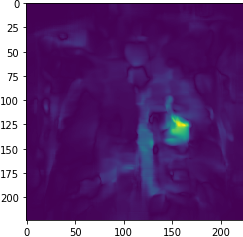

In [286]:
norm = np.sqrt(u ** 2 + v ** 2)
plt.imshow(norm, interpolation='none')

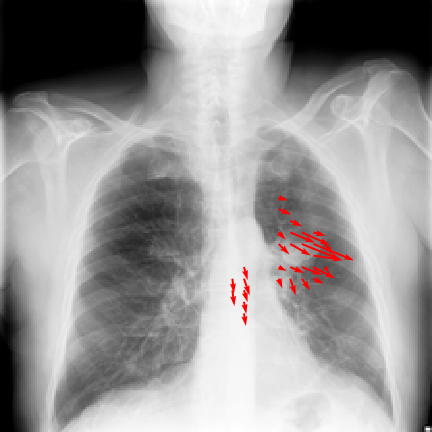

In [293]:
nvec =35  # Number of vectors to be displayed along each image dimension
nl, nc = dimgs[0].shape
step = max(nl//nvec, nc//nvec)

y, x = np.mgrid[:nl:step, :nc:step]
u_ = u[::step, ::step]
v_ = v[::step, ::step]

ar = u_ * v_
u_ = u_ * (ar > np.percentile(ar, 98))
v_ = v_ * (ar > np.percentile(ar, 98))

full_frame()
fig = plt.Figure(figsize=(6, 6), dpi=100)
fig.subplots_adjust(wspace=0, hspace=0);
gcf = plt.gcf()
gcf.set_size_inches(6,6)
fig.set_canvas(gcf.canvas)
plt.imshow(image.cpu().numpy()[0][0], interpolation='none', cmap='Greys_r');
plt.quiver(x, y, u_, v_, color='r', units='dots',
           angles='xy', scale_units='xy', width=2, scale=0.25, minlength=0);
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)